# 1. Get data, import and create functions

In [412]:
from calendar import c
import time
import json
import pandas as pd
import numpy as np
import river
import sys
from sklearn.metrics import mean_absolute_percentage_error
from river import preprocessing, tree, metrics

from kafka import KafkaConsumer
import time
from kafka import KafkaConsumer
import json
import pandas as pd
import river
import time
from river.tree import HoeffdingTreeClassifier
from river.neighbors import KNNClassifier
from river.stream import iter_pandas
from river import metrics
from river import utils

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

import calendar
import math
from river import compose
from river import linear_model
from river import optim
from river import preprocessing

In [413]:
if __name__ == '__main__':

    name = sys.argv[1]
    topic_name = 'project'
    
    # Creation of the Kafka Consumer
    consumer = KafkaConsumer(topic_name, bootstrap_servers="localhost:9092",value_deserializer=lambda m: json.loads(m.decode('utf-8')))#json.dumps(m).decode('utf8'))
    col = ['open_time', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_asset_volume', 'nb_trades',
        'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']
    
    # Creation of a Hoeffding Tree Regressor model
    model = (
            river.preprocessing.StandardScaler() |
            river.tree.HoeffdingTreeRegressor(
                grace_period=200,
                leaf_prediction='adaptive',
                model_selector_decay=0.9
            )
        )
    
    # Iteration over the Consumer
    for i in consumer:
        res = json.loads(json.dumps(i.value))
        df = pd.DataFrame(res, columns=col)
        for i in col:
            df[i] = df[i].astype(float)
        df['open_time'] = df['open_time'].apply(lambda x: datetime.utcfromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M:%S'))
        df = df.set_index('open_time')
        
        print()
        print('----------------------------------------------------------------------')

KeyboardInterrupt: 

In [414]:
def print_progress(y, y_pred, date, sample_id, training_time, testing_time):
    print(f'Samples processed: {sample_id}')
    print(f'Prevision at {date}')
    print(f'Predicted value : {y_pred:.2f}')
    print(f'Real value : {y}')
    print("total train time:" , training_time)
    print("total testing time:",testing_time)

def evaluate(stream, model, verbose = False):

    list_of_trainings = []
    list_of_testings = []
    list_y = []
    list_ypred = []

    training_time = 0
    testing_time = 0
    metric = river.metrics.MAE()    
    metric_mape = river.metrics.SMAPE()

    for i, (x, y) in enumerate(stream):
        # Predict
        start = time.time()
        y_pred = model.predict_one(x)
        end = time.time()
        testing_time = end-start
        list_of_testings.append(testing_time)
        
        # Learn (train)
        start = time.time()
        list_y.append(y)
        list_ypred.append(y_pred)
        m = metric.update(y_pred, y).get()
        m2 = metric_mape.update(y_pred, y).get()
        model.learn_one(x, y)
        end = time.time()
        training_time =  end-start
        list_of_trainings.append(training_time)
        
    # Update metrics and results
    if verbose:
        print_progress(y, y_pred, df.iloc[-1].name,i,sum(list_of_trainings),sum(list_of_testings))
    return y, y_pred, m, m2

In [415]:
#df.to_csv('bitcoin.csv', index=False)

In [424]:
pd.read_csv('bitcoin.csv').head()

,open,high,low,close,volume,close_time,quote_asset_volume,nb_trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,17530.60,17530.73,17525.26,17528.02,190.58561,1.673470e+12,3.340573e+06,3384.0,99.64006,1.746509e+06,0.0
1,17528.01,17533.08,17524.52,17529.25,131.65110,1.673470e+12,2.307722e+06,3191.0,70.96141,1.243909e+06,0.0
2,17528.92,17535.00,17527.06,17529.31,136.71343,1.673470e+12,2.396620e+06,2840.0,78.42198,1.374760e+06,0.0
3,17529.53,17533.00,17528.26,17528.58,130.10384,1.673470e+12,2.280868e+06,2603.0,60.41718,1.059216e+06,0.0
4,17529.00,17535.32,17528.50,17534.56,120.92813,1.673470e+12,2.120177e+06,2943.0,78.37365,1.374095e+06,0.0


In [417]:
df.shape

(1000, 11)

In [430]:
df = pd.read_csv('bitcoin.csv')

In [431]:
df = df[650:]

In [432]:
df[100:351]

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,nb_trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
750,2023-01-12 09:15:00,18146.06,18153.42,18139.21,18140.00,178.36836,1.673515e+12,3.236541e+06,4622.0,81.86657,1.485541e+06,0.0
751,2023-01-12 09:16:00,18140.00,18143.27,18131.05,18132.82,190.83521,1.673515e+12,3.461090e+06,4222.0,66.66411,1.209112e+06,0.0
752,2023-01-12 09:17:00,18132.82,18141.99,18132.42,18141.48,153.86115,1.673515e+12,2.790766e+06,3293.0,105.67036,1.916669e+06,0.0
753,2023-01-12 09:18:00,18140.78,18141.74,18136.35,18138.75,81.97832,1.673515e+12,1.487040e+06,2659.0,37.01909,6.715155e+05,0.0
754,2023-01-12 09:19:00,18138.75,18139.82,18134.03,18135.56,63.55415,1.673515e+12,1.152640e+06,2350.0,22.79419,4.134074e+05,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,2023-01-12 13:20:00,18252.20,18257.05,18246.76,18247.43,206.11351,1.673530e+12,3.761795e+06,6230.0,90.12643,1.644928e+06,0.0
996,2023-01-12 13:21:00,18247.43,18248.00,18215.65,18220.09,601.06591,1.673530e+12,1.095738e+07,11806.0,265.53206,4.840804e+06,0.0
997,2023-01-12 13:22:00,18220.09,18228.15,18206.40,18211.76,426.57337,1.673530e+12,7.770362e+06,11332.0,206.95374,3.769865e+06,0.0
998,2023-01-12 13:23:00,18211.77,18220.67,18194.96,18209.88,504.83179,1.673530e+12,9.191151e+06,10650.0,217.93879,3.968019e+06,0.0


# 2. Online Models

## 2.1. Linear Regression

MAE: 3.055636519804319 ; SMAPE: 0.016764278383043646


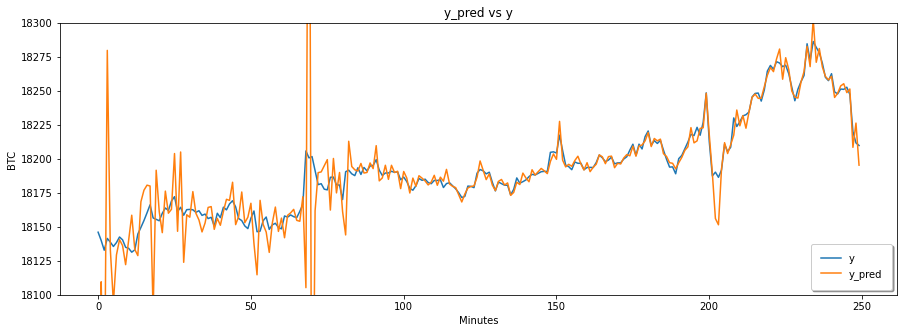

---------- ---------- ---------- ---------- ---------- ----------


In [420]:
model = (
     preprocessing.StandardScaler() |
     linear_model.LinearRegression()
 )

list_y = []
list_ypred = []

for i in range(250):
    
    # Get the 'close' column as the target variable
    y = df[i:100+i].close
    # Get the rest of the columns as the feature variables
    X = df[i:100+i].drop(columns = 'close')
    
    # Get the predicted and actual values
    y, y_pred, m, m2 = evaluate(stream=iter_pandas(X=X, y=y),
                      model=model)
    list_y.append(y)
    list_ypred.append(y_pred)

# Print the MAE and SMAPE metrics
print('MAE:',m,'; SMAPE:',m2)

# Plot the predicted and actual values
plt.figure(figsize = (15, 5))
plt.ylim([18100, 18300])
plt.plot(list_y)
plt.plot(list_ypred)
plt.xlabel("Minutes")
plt.ylabel("BTC")
plt.title("y_pred vs y")
plt.legend(['y','y_pred'], fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

print('---------- ---------- ---------- ---------- ---------- ----------')

MAE: 3.3712420839288093 ; SMAPE: 0.018501314848544396


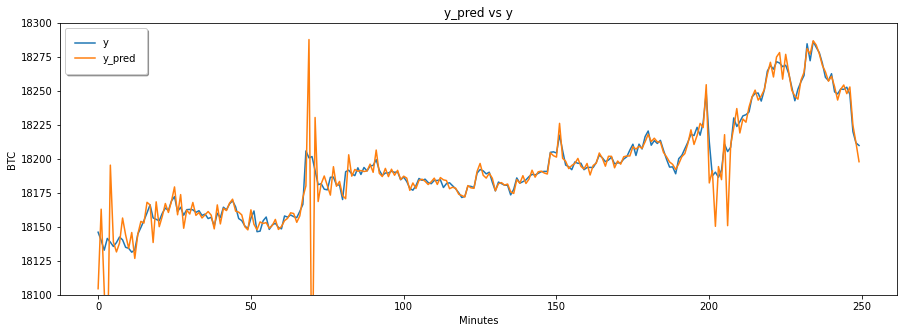

---------- ---------- ---------- ---------- ---------- ----------


In [421]:
model = (
     preprocessing.StandardScaler() |
     linear_model.LinearRegression(
         intercept_lr = 0.25
     )
 )

list_y = []
list_ypred = []

for i in range(250):
    
    # Get the 'close' column as the target variable
    y = df[i:100+i].close
    # Get the rest of the columns as the feature variables
    X = df[i:100+i].drop(columns = 'close')
    
    # Get the predicted and actual values
    y, y_pred, m, m2 = evaluate(stream=iter_pandas(X=X, y=y),
                      model=model)
    list_y.append(y)
    list_ypred.append(y_pred)

# Print the MAE and SMAPE metrics
print('MAE:',m,'; SMAPE:',m2)

# Plot the predicted and actual values
plt.figure(figsize = (15, 5))
plt.ylim([18100, 18300])
plt.plot(list_y)
plt.plot(list_ypred)
plt.xlabel("Minutes")
plt.ylabel("BTC")
plt.title("y_pred vs y")
plt.legend(['y','y_pred'], fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

print('---------- ---------- ---------- ---------- ---------- ----------')

We can see that the linear regression online model doesn't work well during the first 100 minutes and is very versatile (we can fix that a bit increasing the hyperparameter intercept_lr). After these first 100 minutes we can see that it works pretty good.

## 2.2. Hoeffding Tree Regressor

grace_period: 10 ; model_selector_decay: 0.1
MAE: 11.985337491365426 ; SMAPE: 0.06574979617678825


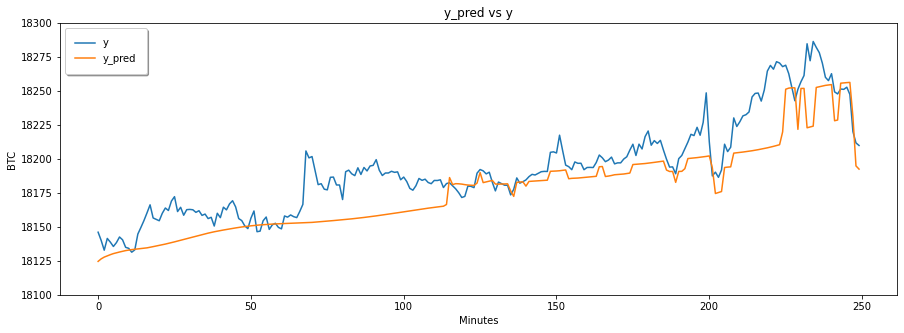

---------- ---------- ---------- ---------- ---------- ----------
grace_period: 10 ; model_selector_decay: 0.5
MAE: 11.985337491365426 ; SMAPE: 0.06574979617678825


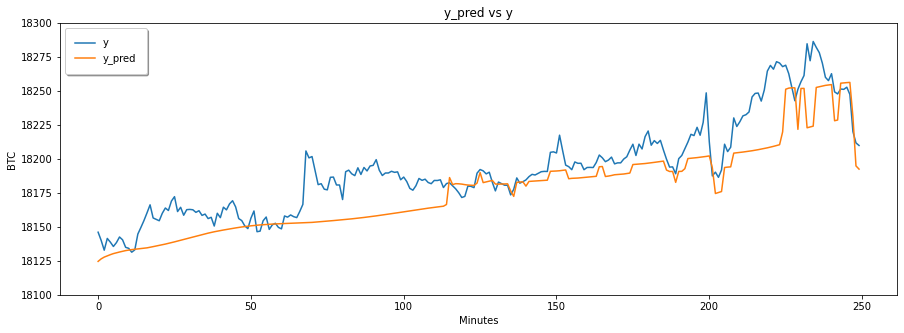

---------- ---------- ---------- ---------- ---------- ----------
grace_period: 10 ; model_selector_decay: 0.9
MAE: 11.985337491365426 ; SMAPE: 0.06574979617678825


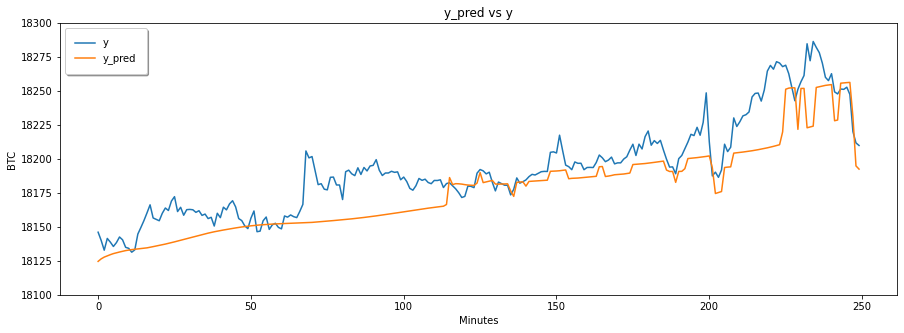

---------- ---------- ---------- ---------- ---------- ----------
grace_period: 100 ; model_selector_decay: 0.1
MAE: 11.907964583697028 ; SMAPE: 0.0652829138513451


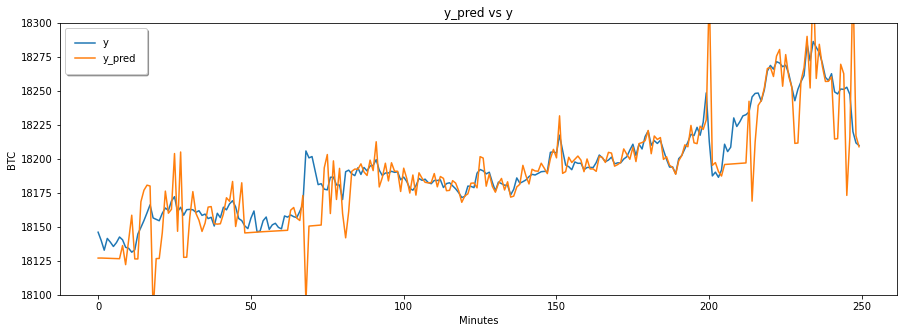

---------- ---------- ---------- ---------- ---------- ----------
grace_period: 100 ; model_selector_decay: 0.5
MAE: 11.798793336423769 ; SMAPE: 0.06469359580970738


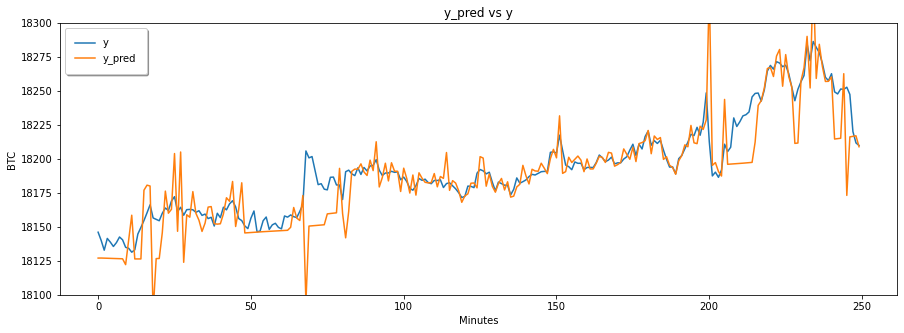

---------- ---------- ---------- ---------- ---------- ----------
grace_period: 100 ; model_selector_decay: 0.9
MAE: 12.099897521185268 ; SMAPE: 0.06637331391719749


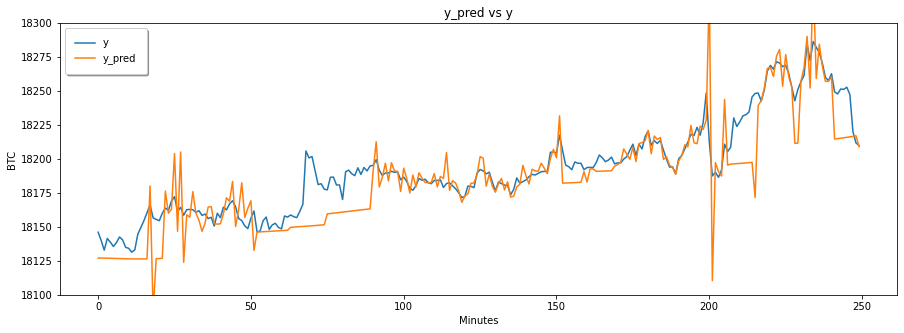

---------- ---------- ---------- ---------- ---------- ----------
grace_period: 200 ; model_selector_decay: 0.1
MAE: 6.2435950506481825 ; SMAPE: 0.0342730414879983


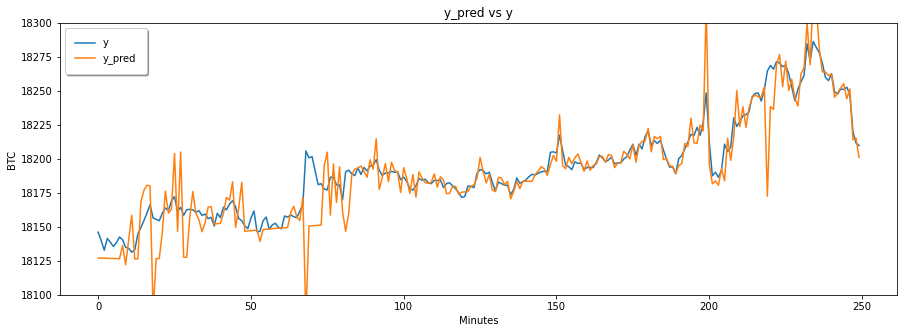

---------- ---------- ---------- ---------- ---------- ----------
grace_period: 200 ; model_selector_decay: 0.5
MAE: 6.199117941220793 ; SMAPE: 0.03402880062139668


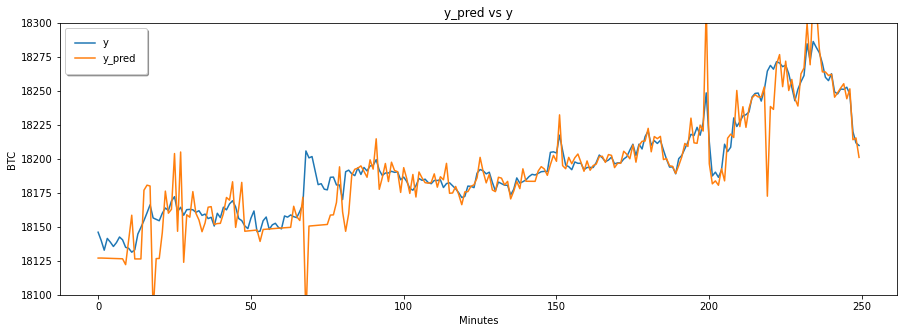

---------- ---------- ---------- ---------- ---------- ----------
grace_period: 200 ; model_selector_decay: 0.9
MAE: 6.111240022371385 ; SMAPE: 0.033546381207092864


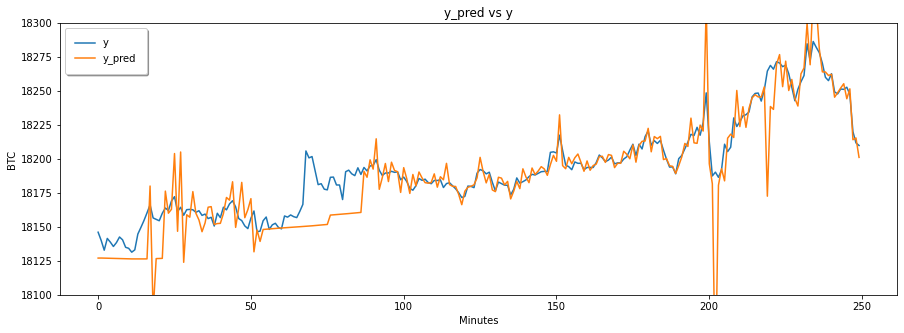

---------- ---------- ---------- ---------- ---------- ----------


In [422]:
grace_periods = [10, 100, 200]
model_selector_decays = [0.1, 0.5, 0.9]

for grace_period in grace_periods:
    for model_selector_decay in model_selector_decays:
        
        model = (
            river.preprocessing.StandardScaler() |
            river.tree.HoeffdingTreeRegressor(
                grace_period=grace_period,
                leaf_prediction='adaptive',
                model_selector_decay=model_selector_decay
            )
        )
        
        list_y = []
        list_ypred = []
        
        for i in range(250):
            
            # Get the 'close' column as the target variable
            y = df[i:100+i].close
            # Get the rest of the columns as the feature variables
            X = df[i:100+i].drop(columns = 'close')
            
            # Get the predicted and actual values
            y, y_pred, m, m2 = evaluate(stream=iter_pandas(X=X, y=y),
                              model=model)
            list_y.append(y)
            list_ypred.append(y_pred)
        
        # Print the MAE and SMAPE metrics
        print('grace_period:', grace_period, '; model_selector_decay:', model_selector_decay)
        print('MAE:',m,'; SMAPE:',m2)
        
        # Plot the predicted and actual values
        plt.figure(figsize = (15, 5))
        plt.ylim([18100, 18300])
        plt.plot(list_y)
        plt.plot(list_ypred)
        plt.xlabel("Minutes")
        plt.ylabel("BTC")
        plt.title("y_pred vs y")
        plt.legend(['y','y_pred'], fancybox=True, framealpha=1, shadow=True, borderpad=1)
        plt.show()
        
        print('---------- ---------- ---------- ---------- ---------- ----------')
        

To conclude with the **HoeffdingTreeRegressor**, we predicted values with tuning 2 hyperparameters :

We know that the **grace_period** is the number of instances a leaf should observe between split attempts. We can see that we get the best score with a grace_period = 200. We can see that with a small grace_period, the time series will be less volatile.

We know that with the **model_selector_decay**, the closer it's to 1, the more importance is going to be given to past observations. On the other hand, if its value approaches 0, the recent observed errors are going to have more influence on the final decision. We get really close values for 0.1, 0.5 and 0.9 but with the grace_period = 200, we could prefer model_selector_decay close to 1.


## 2.3. Hoeffding Adaptive Tree Regressor

grace_period: 10 ; model_selector_decay: 0.1
MAE: 10.360071947267532 ; SMAPE: 0.056842703854019086


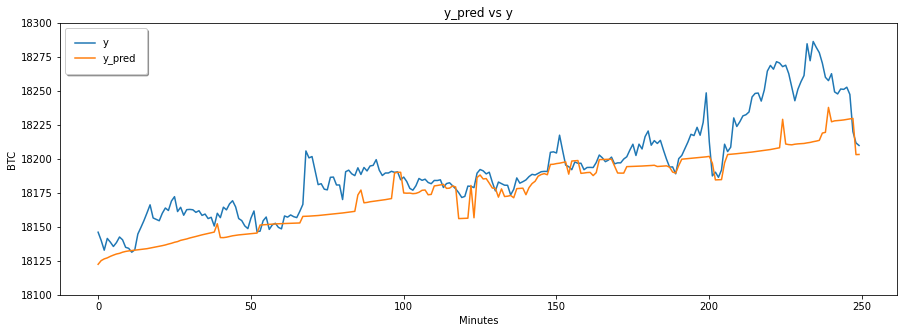

---------- ---------- ---------- ---------- ---------- ----------
grace_period: 10 ; model_selector_decay: 0.5
MAE: 10.385515215055895 ; SMAPE: 0.05698294315562047


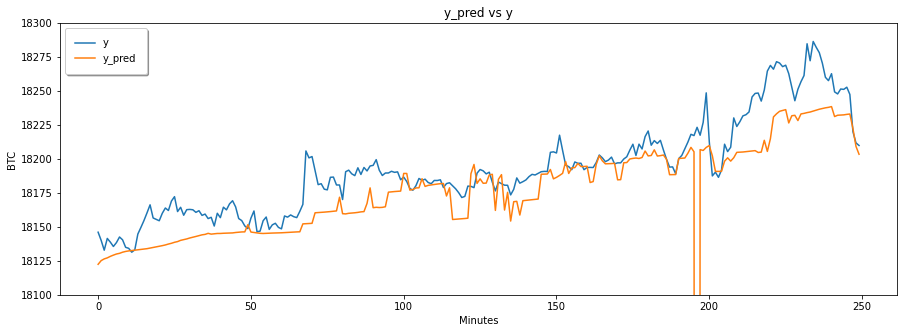

---------- ---------- ---------- ---------- ---------- ----------
grace_period: 10 ; model_selector_decay: 0.9
MAE: 10.316392492097837 ; SMAPE: 0.056571470589711174


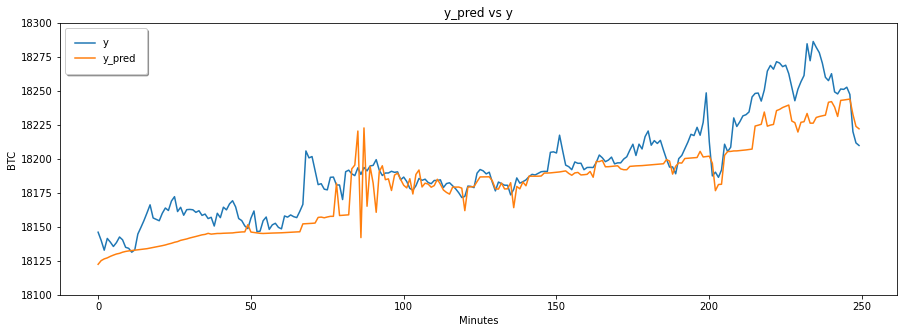

---------- ---------- ---------- ---------- ---------- ----------
grace_period: 100 ; model_selector_decay: 0.1
MAE: 9.404208756012668 ; SMAPE: 0.05159389160481854


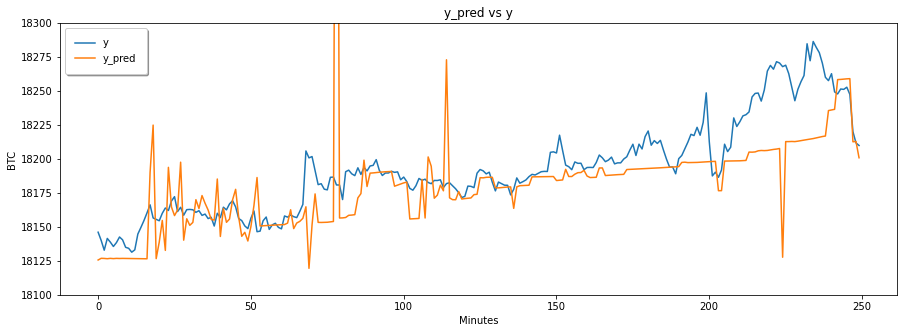

---------- ---------- ---------- ---------- ---------- ----------
grace_period: 100 ; model_selector_decay: 0.5
MAE: 15.62198390829436 ; SMAPE: 0.08571421745046555


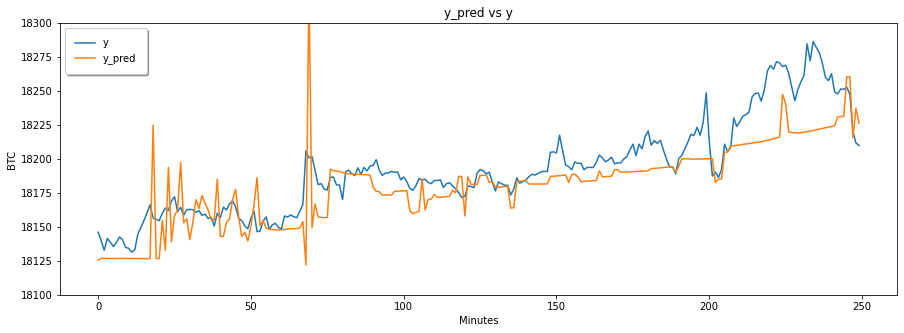

---------- ---------- ---------- ---------- ---------- ----------
grace_period: 100 ; model_selector_decay: 0.9
MAE: 9.916537002455119 ; SMAPE: 0.054371354577071186


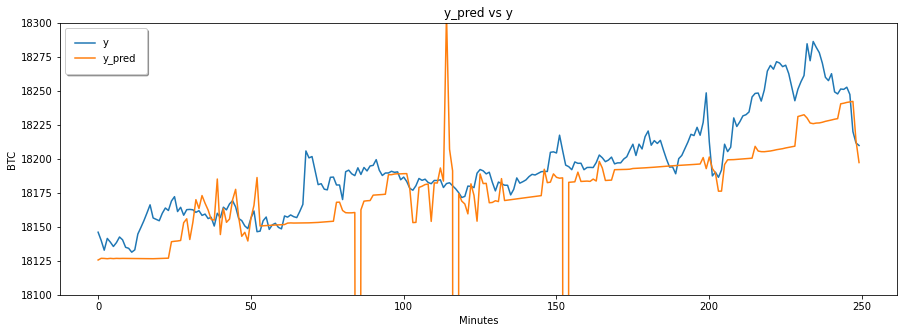

---------- ---------- ---------- ---------- ---------- ----------
grace_period: 200 ; model_selector_decay: 0.1
MAE: 17.436440194411993 ; SMAPE: 0.09563287636306658


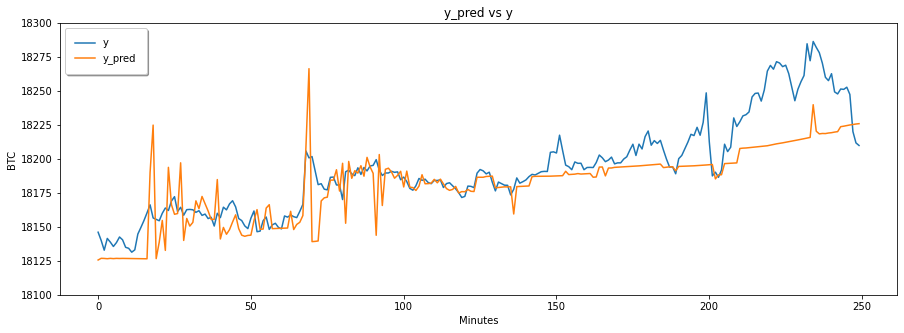

---------- ---------- ---------- ---------- ---------- ----------
grace_period: 200 ; model_selector_decay: 0.5
MAE: 8.99951722955793 ; SMAPE: 0.0494249756654105


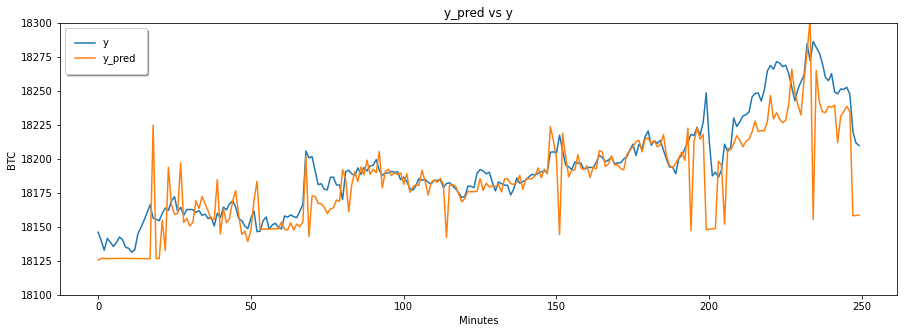

---------- ---------- ---------- ---------- ---------- ----------
grace_period: 200 ; model_selector_decay: 0.9
MAE: 38.050321944769436 ; SMAPE: 0.21629525219746354


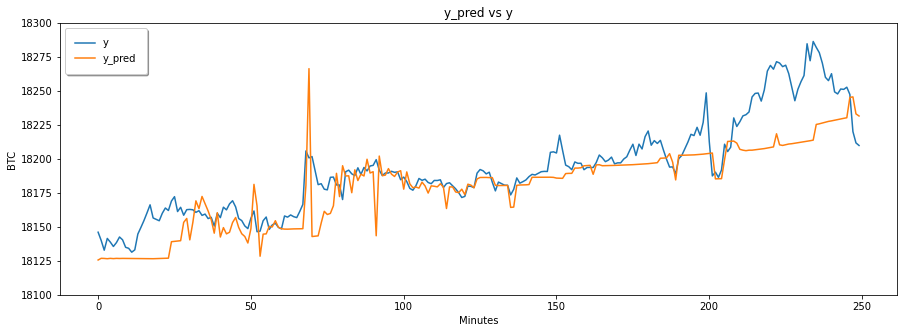

---------- ---------- ---------- ---------- ---------- ----------


In [423]:
grace_periods = [10, 100, 200]
model_selector_decays = [0.1, 0.5, 0.9]

for grace_period in grace_periods:
    for model_selector_decay in model_selector_decays:
        
        model = (
            river.preprocessing.StandardScaler() |
            river.tree.HoeffdingAdaptiveTreeRegressor(
                grace_period=grace_period,
                leaf_prediction='adaptive',
                model_selector_decay=model_selector_decay,
                seed=0
            )
        )
        
        list_y = []
        list_ypred = []
        
        for i in range(250):
            
            # Get the 'close' column as the target variable
            y = df[i:100+i].close
            # Get the rest of the columns as the feature variables
            X = df[i:100+i].drop(columns = 'close')
            
            # Get the predicted and actual values
            y, y_pred, m, m2 = evaluate(stream=iter_pandas(X=X, y=y),
                              model=model)
            list_y.append(y)
            list_ypred.append(y_pred)
            
        # Print the MAE and SMAPE metrics
        print('grace_period:', grace_period, '; model_selector_decay:', model_selector_decay)
        print('MAE:',m,'; SMAPE:',m2)
        
        # Plot the predicted and actual values
        plt.figure(figsize = (15, 5))
        plt.ylim([18100, 18300])
        plt.plot(list_y)
        plt.plot(list_ypred)
        plt.xlabel("Minutes")
        plt.ylabel("BTC")
        plt.title("y_pred vs y")
        plt.legend(['y','y_pred'], fancybox=True, framealpha=1, shadow=True, borderpad=1)
        plt.show()
        
        print('---------- ---------- ---------- ---------- ---------- ----------')

The difference with HoeffdingTreeRegressor is that if a drift is detected in a node, an alternate tree begins to be induced in the background. When enough information is gathered, HATR swaps the node where the change was detected by its alternate tree.

To conclude with the **HoeffdingAdaptativeTreeRegressor**, we predicted values with tuning 2 hyperparameters :

We know that the **grace_period** is the number of instances a leaf should observe between split attempts. We can see that we get the best score with a grace_period = 200. We can see that with a small grace_period, the time series will be less volatile.

We know that with the **model_selector_decay**, the closer it's to 1, the more importance is going to be given to past observations. On the other hand, if its value approaches 0, the recent observed errors are going to have more influence on the final decision. We get really close values for 0.1, 0.5 and 0.9 but with the grace_period = 200, we could prefer model_selector_decay at 0.5.


## 2.4. SNARIMAX

In [411]:
model = (
    time_series.SNARIMAX(
        p=0,
        d=0,
        q=0,
        m=100,
        sp=100,
        sq=100,
        regressor=(
            preprocessing.StandardScaler() |
            linear_model.LinearRegression(
                intercept_init=110,
                optimizer=optim.SGD(0.01),
                intercept_lr=0.3
            )
        )
    
))

In [409]:
def evaluate_SNARIMAX(model, h, Y_t, n_iter):
    preds = []
    metric = river.metrics.MAE()
    metric_mape = river.metrics.SMAPE()
    for i in range(n_iter):
        
        y_pred = model.forecast(horizon=10)
        preds.append(y_pred[h-1])
        
        model = model.learn_one(Y_t[i])
        if i > 10:
            m = metric.update(y_pred[h-1], Y_t[i + h]).get()
            m2 = metric_mape.update(y_pred[h-1], Y_t[i + h]).get()

    return metric, metric_mape, preds

h: 1 ; n_iter: 349
MAE: 6.912588 SMAPE: 0.038017


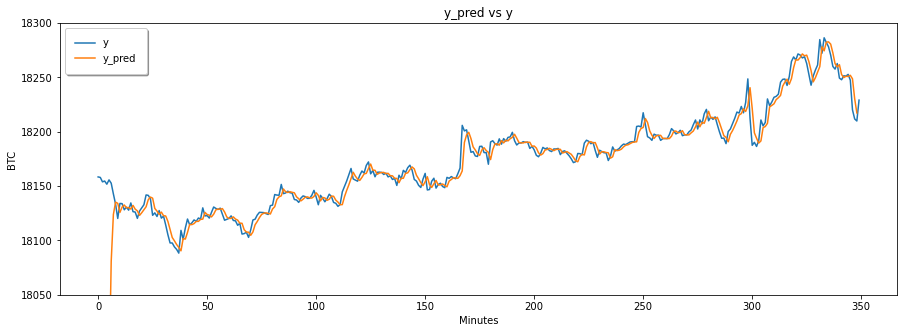

---------- ---------- ---------- ---------- ---------- ----------
h: 5 ; n_iter: 345
MAE: 11.651803 SMAPE: 0.064076


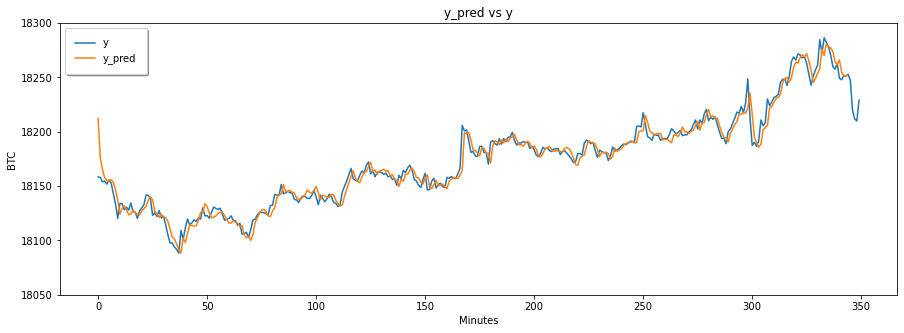

---------- ---------- ---------- ---------- ---------- ----------
h: 10 ; n_iter: 340
MAE: 14.42841 SMAPE: 0.079377


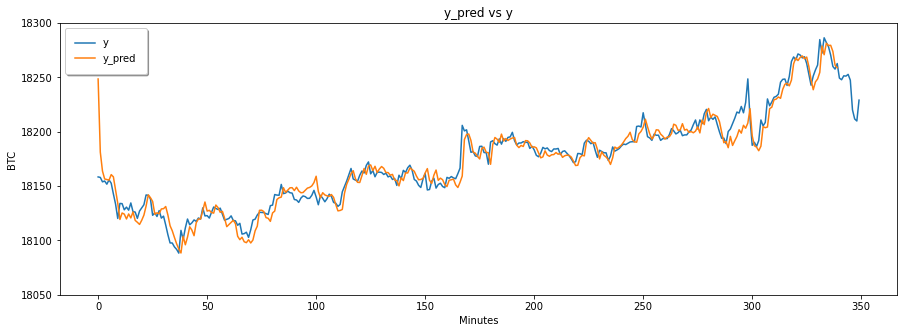

---------- ---------- ---------- ---------- ---------- ----------


In [407]:
Y_t = df['close'].values
lst_h_niter = [1, 349, 5, 345, 10, 340]
lst_h_niter = np.array(lst_h_niter).reshape((3,2))

for h, n_iter in lst_h_niter:
    m, m2, list_ypred = evaluate_SNARIMAX(model, h, Y_t, n_iter)
    
    print('h:', h, '; n_iter:', n_iter)
    print(m, m2)

    plt.figure(figsize = (15, 5))
    plt.ylim([18050, 18300])
    plt.plot(Y_t)
    plt.plot(list_ypred)
    plt.xlabel("Minutes")
    plt.ylabel("BTC")
    plt.title("y_pred vs y")
    plt.legend(['y','y_pred'], fancybox=True, framealpha=1, shadow=True, borderpad=1)
    plt.show()
        
    print('---------- ---------- ---------- ---------- ---------- ----------')

Explanation of our hyperparameters: 

- **horizon** = 10 means that SNARIMAX model will predict next 10 values.
- **h** = 1 means that we will keep the first prediction of the 10 values predicted (we keep the next first minute).

SNARIMAX model seems to be really efficient in our case, compared to previous online models used.

# 3. Conclusion

**Online models:**

Hoeffding Tree Regressor and Hoeffding Adaptive Tree Regressor are both forms of online decision tree regression models. The key difference between the two is that the Hoeffding Adaptive Tree Regressor uses an adaptive mechanism to decide when to split a node in the tree, whereas the Hoeffding Tree Regressor splits nodes based on a fixed threshold.

Online Linear Regression is a method for updating linear regression models in an online, incremental fashion. It can be used for data streams with a large number of instances and limited memory.

SNARIMAX is a type of online algorithm for fitting linear models with sparse and non-sparse constraints. It is a variant of the Sparse Non-Negative Garrote (Sparse NNG) algorithm, which is an iterative method for fitting sparse linear models.

It is difficult to say which online model would make the best predictions without knowing more about the specific problem and dataset. Each model has its own strengths and weaknesses, and the best model for a given task will depend on the characteristics of the data and the goals of the problem.

For example, Hoeffding Tree Regressor and Hoeffding Adaptive Tree Regressor are suitable for problems where the data is highly non-linear and the number of features is high, while online Linear Regression is a good choice for problems with a large number of instances and limited memory.

SNARIMAX is suitable for problems with sparse and non-sparse constraints, where linear models are used to fit the data.

In general, it's a good idea to try multiple models and compare their performance using metrics such as accuracy, precision, and recall. The model with the highest performance metrics is the one that makes the best predictions.